# Natural Images classification with CNN

## Import and Process Data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download -d prasunroy/natural-images

 97% 332M/342M [00:03<00:00, 99.1MB/s]
100% 342M/342M [00:03<00:00, 112MB/s] 


In [ ]:
!unzip -q natural-images.zip

In [ ]:
import numpy as np 
import pandas as pd
import random
import os


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from pathlib import Path

from PIL import Image

%matplotlib inline

In [ ]:
# Set device:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

In [ ]:
data_dir = "./natural_images"

In [ ]:
# Let's have a look at what there is inside the data folder:
os.listdir(data_dir)

['motorbike', 'flower', 'car', 'cat', 'dog', 'fruit', 'airplane', 'person']

In [ ]:
for cls in sorted(os.listdir(data_dir)):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

airplane : 727
car : 968
cat : 885
dog : 702
flower : 843
fruit : 1000
motorbike : 788
person : 986


In [ ]:
# Transformations:
data_transform = transforms.Compose([  
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ])

In [ ]:
# Import the data into PyTorch using the ImageFolder class:
dx = ImageFolder(data_dir, transform=data_transform)  

In [ ]:
# Let's check the species once again:
dx.classes

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']

In [ ]:
# Check the total number of flowers:
len(dx)

6899

In [ ]:
# Define a function to show a picture:
def show_image(img, label):
  print('Label: ', dx.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0))

Label:  cat (2)


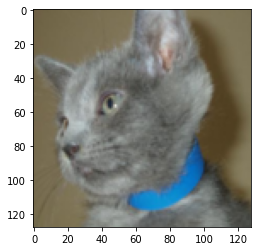

In [ ]:
show_image(*dx[2000]) # use a different value to visualize other images

In [ ]:
# Split the data into training, validation and test sets:
validation_size = 1376
training_size = len(dx) - validation_size

train_ds, val_ds_main = random_split(dx,[training_size, validation_size], generator=torch.Generator().manual_seed(40))
val_ds, test_ds  = random_split(val_ds_main,[688, 688], generator=torch.Generator().manual_seed(40))

print(f"{len(train_ds)} samples used as training set")
print(f"{len(val_ds)}  samples used as validation set")
print(f"{len(test_ds)}  samples used as test set")

5523 samples used as training set
688  samples used as validation set
688  samples used as test set


In [ ]:
# Define the loaders:
train_loader = DataLoader(train_ds, batch_size=32 , drop_last=True, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, drop_last=False, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, drop_last=False, shuffle=False)

In [ ]:
# Define dictionary of loaders:
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

## Modeling

### Conv4
4 Conv layers + FC + Classifier

In [ ]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Let's check the output size:

# Get an element from the dataset:
image_x, _ = train_ds[0] 

# Get the size of a sample:
image_x.size() # we get a tensor with 3 dimensions   

torch.Size([3, 128, 128])

In [ ]:
# image_x is a tensor with 3 dimensions, but the 2D CNN model expects as input a tensor with 
# 4 dimensions. Therefore, in order to use `test_x` as input of the model, I have to add the 
# batch dimension to it:
image_x = image_x.unsqueeze(dim=0)
image_x.size() 

torch.Size([1, 3, 128, 128])

In [ ]:
# Pass image_x to the model:
output = model(image_x)
output.shape

torch.Size([1, 64, 1, 1])

In [ ]:
# Let's check what is the number of features that will be the input of the first linear layer:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

64


In [ ]:
class CNN(nn.Module):
  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 4
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Create fully-connected layers (2 linear layers, in this case):
    self.fc_layers = nn.Sequential(
        # FC layer
        nn.Linear(64, 50),
        nn.ReLU(),
        # Classification Layer
        nn.Linear(50, 8)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer (linear part), we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model:
model = CNN()
output = model(image_x)
output.shape

torch.Size([1, 8])

In [ ]:
# Define an optimizier:
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Define a loss:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=64, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=8, bias=True)
  )
)
Epoch 1: TrL=1.6402, TrA=0.3465, VL=1.3662, VA=0.4688, TeL=1.3300, TeA=0.4730,
Epoch 2: TrL=1.3250, TrA=0.4904, VL=1.2725, VA=0.5412, TeL=1.2272, TeA=0.5384,
Epoch 3: TrL=1.1116, Tr

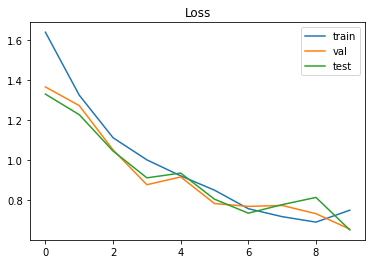

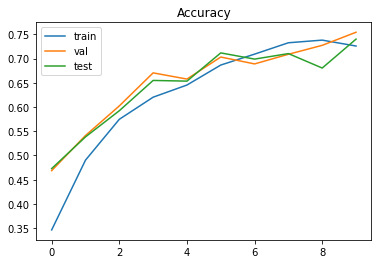

In [ ]:
# Train model:
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

In [ ]:
# Define a function to look at predictions:
def predict_image(img, model):
    # Get predictions from model
    img = (img.unsqueeze(dim=0)).to(dev)
    yb = model(img)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dx.classes[preds[0].item()]

Label: fruit , Predicted: fruit


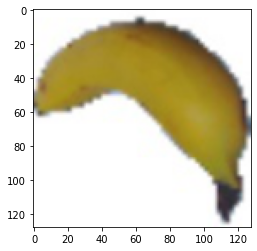

In [ ]:
# Look at an image correctly classified:
img, label = test_ds[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dx.classes[label], ', Predicted:', predict_image(img, model))

### Conv3
3 Conv layers + FC + Classifier

In [ ]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Let's check the output size:
image_x, _ = train_ds[0] 

# Get the size of a sample:
image_x.size()

torch.Size([3, 128, 128])

In [ ]:
image_x = image_x.unsqueeze(dim=0)
image_x.size() 

torch.Size([1, 3, 128, 128])

In [ ]:
# Pass image_x to the model:
output = model(image_x)
output.shape

torch.Size([1, 32, 4, 4])

In [ ]:
# Let's check what is the number of features that will be the input of the first linear layer:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

512


In [ ]:
class CNN(nn.Module):
  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    # Create fully-connected layers (2 linear layers, in this case):
    self.fc_layers = nn.Sequential(
        # First FC layer
        nn.Linear(512, 50),
        nn.ReLU(),
        # Final Classification Layer
        nn.Linear(50, 8)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer (linear part), we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model:
model = CNN()
output = model(image_x)
output.shape

torch.Size([1, 8])

In [ ]:
# Define an optimizier:
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Define a loss:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=512, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=8, bias=True)
  )
)
Epoch 1: TrL=1.4382, TrA=0.4586, VL=1.1246, VA=0.5866, TeL=1.1613, TeA=0.5810,
Epoch 2: TrL=0.9920, TrA=0.6350, VL=0.8928, VA=0.6776, TeL=0.9394, TeA=0.6335,
Epoch 3: TrL=0.8113, TrA=0.7100, VL=0.8512, VA=0.6747, TeL=0.8998, TeA=0.6577,
Epoch 4: TrL=0.7207, TrA=0.7547, VL=0.6670, VA=0.7571, TeL=0.7077, TeA=0.7287,
Epoch 5: TrL=0.6732, TrA=0.7640, VL=0.67

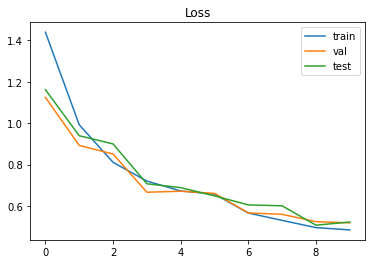

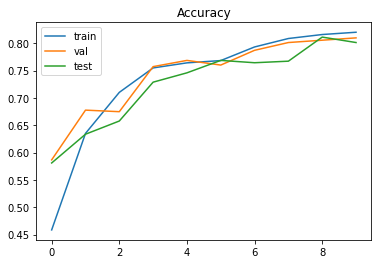

In [ ]:
# Train model:
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

### Conv2
2 Conv layers + FC + Classifier

In [ ]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Let's check the output size:
image_x, _ = train_ds[0] 

# Get the size of a sample:
image_x.size()

torch.Size([3, 128, 128])

In [ ]:
image_x = image_x.unsqueeze(dim=0)
image_x.size() 

torch.Size([1, 3, 128, 128])

In [ ]:
# Pass image_x to the model:
output = model(image_x)
output.shape

torch.Size([1, 16, 16, 16])

In [ ]:
# Let's check what is the number of features that will be the input of the first linear layer:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

4096


In [ ]:
class CNN(nn.Module):
  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    # Create fully-connected layers (2 linear layers, in this case):
    self.fc_layers = nn.Sequential(
        # First FC layer
        nn.Linear(4096, 1024),
        nn.ReLU(),
        # Final Classification Layer
        nn.Linear(1024, 8)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer (linear part), we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model:
model = CNN()
output = model(image_x)
output.shape

torch.Size([1, 8])

In [ ]:
# Define an optimizier:
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Define a loss:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=8, bias=True)
  )
)
Epoch 1: TrL=1.3159, TrA=0.5527, VL=0.9693, VA=0.6278, TeL=0.9351, TeA=0.6491,
Epoch 2: TrL=0.7324, TrA=0.7351, VL=0.6406, VA=0.7571, TeL=0.6632, TeA=0.7699,
Epoch 3: TrL=0.5895, TrA=0.7842, VL=0.5979, VA=0.7713, TeL=0.6501, TeA=0.7401,
Epoch 4: TrL=0.5177, TrA=0.8140, VL=0.5425, VA=0.7983, TeL=0.5397, TeA=0.7983,
Epoch 5: TrL=0.4452, TrA=0.8385, VL=0.5268, VA=0.7955, TeL=0.5263, TeA=0.8082,
Epoch 6: TrL=0.3872, TrA=0.8563, VL=0.4155, VA=0.8466, TeL=0.4298, TeA=0.8310,
Epoch 7: TrL=0.3790, TrA=0.8661, VL=0.5046, VA=0.815

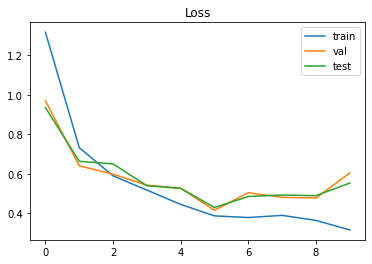

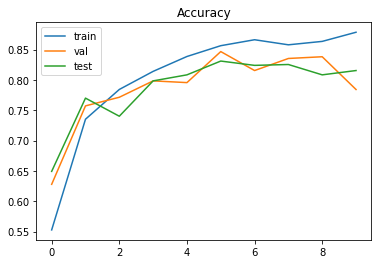

In [ ]:
# Train model:
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)

### Conv1
1 Conv layer + FC + Classifier

In [ ]:
class SimpleCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [ ]:
# Create the model:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [ ]:
# Let's check the output size:
image_x, _ = train_ds[0] 

# Get the size of a sample:
image_x.size()

torch.Size([3, 128, 128])

In [ ]:
image_x = image_x.unsqueeze(dim=0)
image_x.size() 

torch.Size([1, 3, 128, 128])

In [ ]:
# Pass image_x to the model:
output = model(image_x)
output.shape

torch.Size([1, 8, 32, 32])

In [ ]:
# Let's check what is the number of features that will be the input of the first linear layer:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

8192


In [ ]:
class CNN(nn.Module):
  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    
    # Create fully-connected layers (2 linear layers, in this case):
    self.fc_layers = nn.Sequential(
        # First FC layer
        nn.Linear(8192, 1024),
        nn.ReLU(),
        # Final Classification Layer
        nn.Linear(1024, 8)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer (linear part), we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [ ]:
# Create the model:
model = CNN()
output = model(image_x)
output.shape

torch.Size([1, 8])

In [ ]:
# Define an optimizier:
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Define a loss:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=8, bias=True)
  )
)
Epoch 1: TrL=1.7598, TrA=0.4833, VL=1.0585, VA=0.6222, TeL=1.0703, TeA=0.6122,
Epoch 2: TrL=0.9934, TrA=0.6443, VL=0.9859, VA=0.6534, TeL=0.9576, TeA=0.6378,
Epoch 3: TrL=0.8599, TrA=0.6860, VL=0.9536, VA=0.6605, TeL=0.9682, TeA=0.6349,
Epoch 4: TrL=0.7626, TrA=0.7207, VL=0.8941, VA=0.6761, TeL=0.8140, TeA=0.7045,
Epoch 5: TrL=0.7379, TrA=0.7315, VL=0.8699, VA=0.6847, TeL=0.7923, TeA=0.6932,
Epoch 6: TrL=0.6905, TrA=0.7504, VL=0.8194, VA=0.6918, TeL=0.7463, TeA=0.7216,
Epoch 7: TrL=0.6135, TrA=0.7714, VL=0.8408, VA=0.7159, TeL=0.8422, TeA=0.6918,
Epoch 8: TrL=0.6000, TrA=0.7878, VL=0.8713, VA=0.6889, TeL=0.83

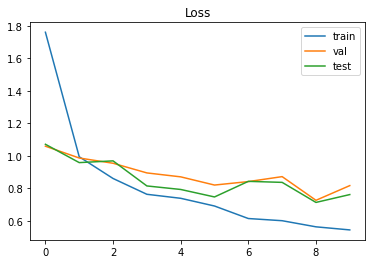

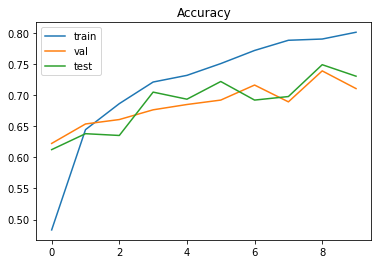

In [ ]:
# Train model:
train(model, loaders, optimizer, criterion, epochs=10, dev=dev)